# Digit Classification:

In this tutorial we are going to demostrate classification of 0-1 images from the MNIST dataset by using AdaBoost algorithm.

We start by some usefull import 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

Now we import the Mnist data and save only the images of 0-1. you can see some examples from the dataset below.

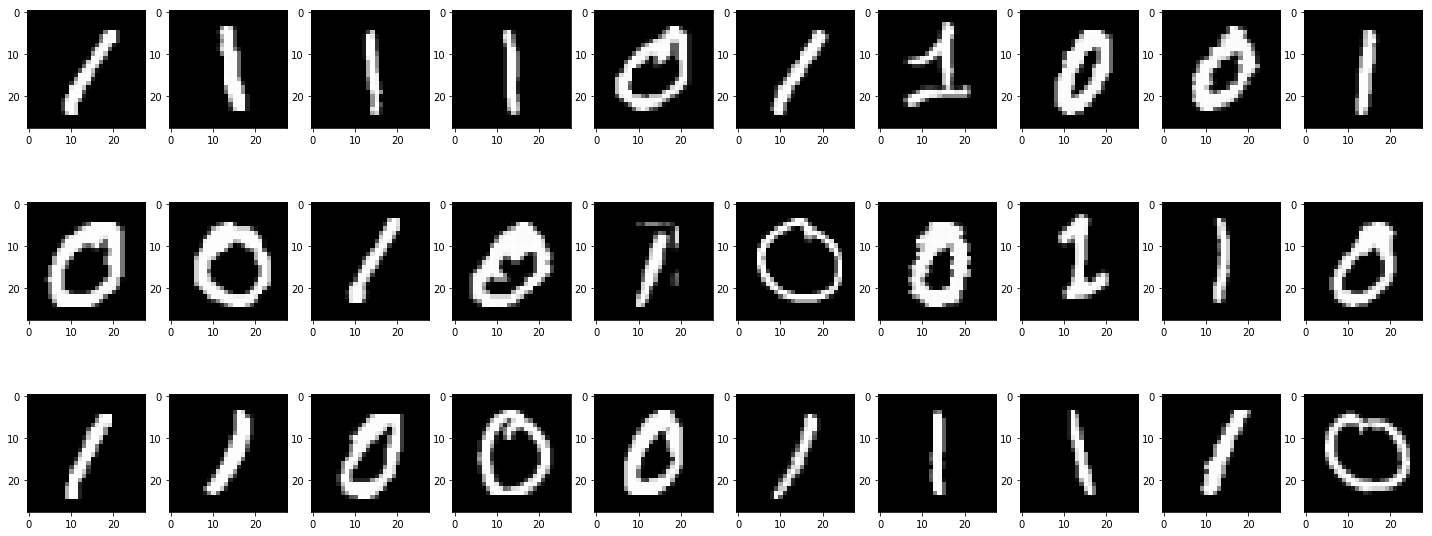

In [2]:
mnist = tf.keras.datasets.mnist


def get_2_labels(first_digit, second_digit):
    (x_train, y_train),(x_test, y_test) = mnist.load_data()

    x_train = (x_train / 255.0 * 2 - 1).reshape(x_train.shape[0], -1)
    x_test = (x_test / 255.0 * 2 - 1).reshape(x_test.shape[0], -1)

    train_images = np.logical_or((y_train == first_digit), (y_train == second_digit))
    test_images = np.logical_or((y_test == first_digit), (y_test == second_digit))
    return x_train[train_images], y_train[train_images], x_test[test_images], y_test[test_images]

x_train, y_train, x_test, y_test = get_2_labels(0, 1)

plt.figure(figsize=(25,10))
for i in range(1, 31):
    ax = plt.subplot(3, 10, i) 
    ax.imshow(x_train[i].reshape(28, 28), cmap=plt.cm.gray)


In [3]:
y_train.size, y_test.size

(12665, 2115)

And use various number of weak learners to learn classifier. for each number check:
*   train error
*   test error



# Linear Classifer

In [4]:
def linearClassify(x_train, y_train, x_test, y_test):
   
    # by default - SVM Classifier
    clf = SGDClassifier()
    
    clf.fit(x_train, y_train)
    
    train_prediction = clf.predict(x_train)
    train_error = np.mean(train_prediction != y_train)
    
    test_prediction = clf.predict(x_test)
    test_error = np.mean(test_prediction != y_test)
    
    return train_error, test_error

In [5]:
%%time

# how many indices to use - (start with 2 - sometimes fails)
num_of_indices = np.arange(1,x_train.shape[1]+1,7)

array_size = num_of_indices.size

#arrays for graphs
test_errors_arr = [0] * array_size
train_errors_arr = [0] * array_size

# pick increasing number of indices
for i,num_ind in enumerate(num_of_indices):
    indices = np.random.permutation(x_train.shape[1])[:num_ind]
  
  # compute elapsed time
    train_error, test_error = linearClassify(x_train[: , indices], y_train, x_test[: , indices], y_test)
  
    test_errors_arr[i] = test_error
    train_errors_arr[i] = train_error

Wall time: 38.3 s


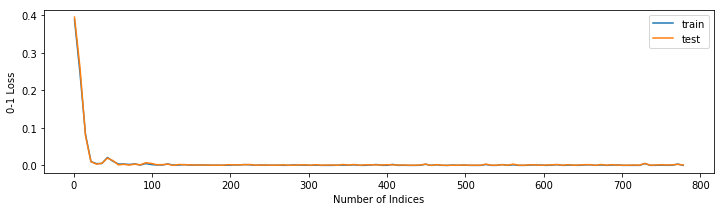

In [6]:
# plot train and test error
plt.figure(figsize=(12, 3))
plt.plot(num_of_indices, train_errors_arr, num_of_indices, test_errors_arr)
plt.xlabel('Number of Indices')
plt.ylabel('0-1 Loss')
plt.legend(('train','test'))
plt.show()

In [7]:
# Save the result with all the indices

reps = 10 # repeat for more robustness
mean_svm_train_error = 0
mean_svm_test_error = 0

for _ in range(reps):
    svm_train_error, svm_test_error = linearClassify(x_train, y_train, x_test, y_test)
    mean_svm_train_error += svm_train_error / reps
    mean_svm_test_error += svm_test_error / reps
mean_svm_train_error, mean_svm_test_error

(0.00022897749703908413, 0.0008037825059101653)

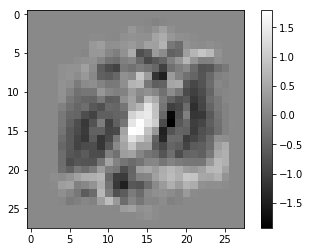

In [8]:
clf = SGDClassifier()
clf.fit(x_train, y_train)
plt.imshow(np.reshape(clf.coef_,(28,28)), cmap=plt.cm.gray)
plt.colorbar()
plt.show()

# AdaBoost

In [9]:
%%time

num_weak_learners = [1, 5, 10, 20,35, 50]

def train_adaboost(x_train, y_train, x_test, y_test):
    train_error = []
    test_error = []
    
    for T in num_weak_learners: 
        adaboost = AdaBoostClassifier(algorithm='SAMME', n_estimators=T)
        adaboost.fit(x_train, y_train)

        test_prediction = adaboost.predict(x_test)

        train_prediction = adaboost.predict(x_train)

        test_error.append(sum(1 - (test_prediction == y_test)) / len(test_prediction))
        train_error.append(sum(1 - (train_prediction == y_train)) / len(train_prediction))
        print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, test_prediction))

    return train_error, test_error, adaboost

train_error, test_error, adaboost = train_adaboost(x_train, y_train, x_test, y_test)

Confusion matrix:
[[ 969   11]
 [   9 1126]]
Confusion matrix:
[[ 975    5]
 [   9 1126]]
Confusion matrix:
[[ 973    7]
 [   1 1134]]
Confusion matrix:
[[ 976    4]
 [   1 1134]]
Confusion matrix:
[[ 978    2]
 [   0 1135]]
Confusion matrix:
[[ 978    2]
 [   0 1135]]
Wall time: 48.9 s


We can see how the training loss decrease to zero and how the test loss stay on low value.

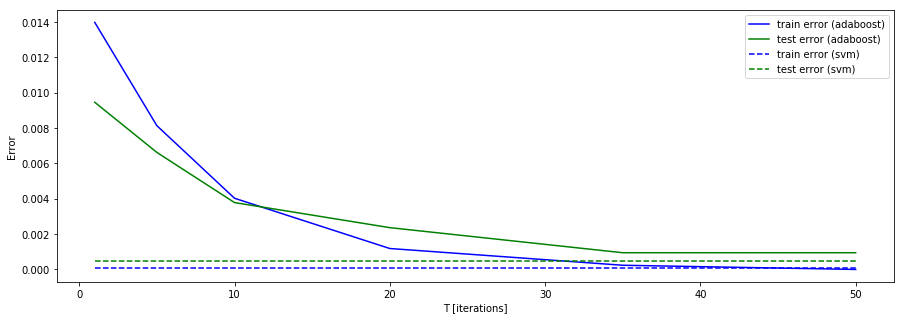

In [10]:
fig = plt.figure(figsize=(15,5))

plt.plot(num_weak_learners, train_error, 'b', label='train')
plt.plot(num_weak_learners, test_error, 'g', label='test')
plt.plot([1,50], [svm_train_error, svm_train_error], 'b--')
plt.plot([1,50], [svm_test_error, svm_test_error], 'g--')
plt.legend(('train error (adaboost)', 'test error (adaboost)', 'train error (svm)', 'test error (svm)'))
plt.xlabel('T [iterations]')
plt.ylabel('Error')
plt.show()

Observations:


*   The strongest labels consentrated in the areas where 1-0 are different
*   As we take more classifiers we get them in more areas.
*   The corners of the image are empty since the pixels in that area are empty- both for 1 and 0.



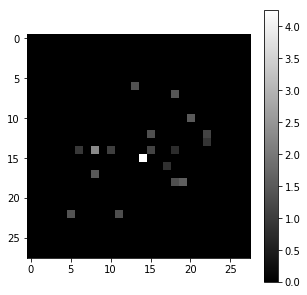

In [11]:
num_features_to_plot = 19
features = np.zeros(28 * 28)
for i in range(num_features_to_plot):
    features[adaboost.estimators_[i].tree_.feature[0]] = adaboost.estimator_weights_[i]# * adaboost.estimators_[i].tree_.threshold[0]

fig = plt.figure(figsize=(5,5))
plt.imshow(features.reshape(28, 28), cmap=plt.cm.gray)
plt.colorbar()
plt.show()

### Now repeat for the digits 8-9: note that it is harder to seperate 8-9, thus the error decreasing slower.

# Bootstrap

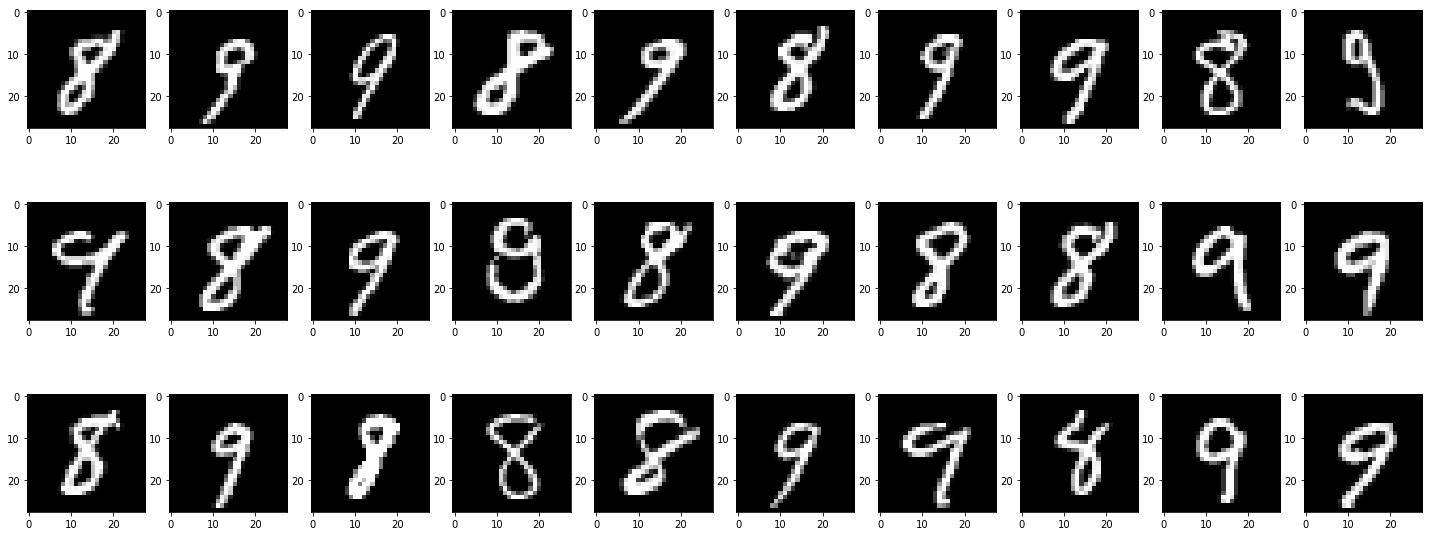

In [87]:
x_train, y_train, x_test, y_test = get_2_labels(8, 9)

plt.figure(figsize=(25,10))
for i in range(1, 31):
    ax = plt.subplot(3, 10, i) 
    ax.imshow(x_train[i].reshape(28, 28), cmap=plt.cm.gray)

In [106]:
# Save the SVM results
reps = 10
mean_svm_train_error = 0
mean_svm_test_error = 0
for _ in range(reps):
    svm_train_error, svm_test_error = linearClassify(x_train, y_train, x_test, y_test)
    mean_svm_train_error += svm_train_error / reps
    mean_svm_test_error += svm_test_error / reps
mean_svm_train_error, mean_svm_test_error

(0.016516949152542374, 0.028290468986384265)

In [124]:
m = y_train.size
sample_size = np.array([m/2, 0.75*m, m, 1.25*m, 1.5*m, 2*m]).astype(np.int)

In [125]:
%%time

reps = 10
array_size = sample_size.size

#arrays for graphs
test_errors_arr = [0] * array_size
train_errors_arr = [0] * array_size


# pick increasing number of indices
for i,num_samples in enumerate(sample_size):
    for _ in range(reps):
        indices = np.random.randint(0, m, size=num_samples)

        train_error, test_error = linearClassify(x_train, y_train, x_test, y_test)

        test_errors_arr[i] += test_error / reps
        train_errors_arr[i] += train_error / reps

Wall time: 1min 4s


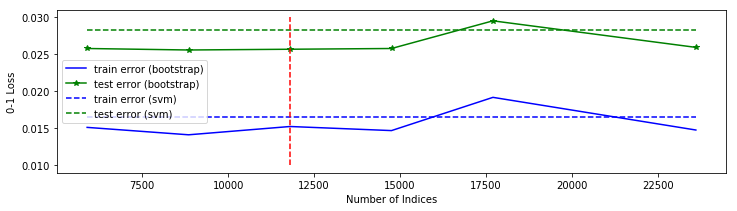

In [126]:
# plot train and test error
plt.figure(figsize=(12, 3))
plt.plot(sample_size, train_errors_arr, 'b', sample_size, test_errors_arr, 'g*-')
plt.plot([sample_size[0],sample_size[-1]], [mean_svm_train_error, mean_svm_train_error], 'b--')
plt.plot([sample_size[0],sample_size[-1]], [mean_svm_test_error, mean_svm_test_error], 'g--')
plt.xlabel('Number of Indices')
plt.ylabel('0-1 Loss')
plt.legend(('train error (bootstrap)', 'test error (bootstrap)', 'train error (svm)', 'test error (svm)'))
plt.plot([m, m], [0.01, 0.03], 'r--')
plt.show()